In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# import wget
# url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
# wget.download(url)

In [49]:
import numpy as np
import json
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])
data = np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

In [50]:
text

array(['how much is an overdraft fee for bank',
       'why are exponents preformed before multiplication in the order of operations',
       'what size wipers does this car take', ...,
       "do you know why my card was declined at target i can't figure out why",
       "i can't figure out why my card was declined at target",
       "i was just at target and they declined my card and i can't understand why"],
      dtype='<U136')

In [51]:
label_list = set(labels)

In [52]:
label_list

{'accept_reservations',
 'account_blocked',
 'alarm',
 'application_status',
 'apr',
 'are_you_a_bot',
 'balance',
 'bill_balance',
 'bill_due',
 'book_flight',
 'book_hotel',
 'calculator',
 'calendar',
 'calendar_update',
 'calories',
 'cancel',
 'cancel_reservation',
 'car_rental',
 'card_declined',
 'carry_on',
 'change_accent',
 'change_ai_name',
 'change_language',
 'change_speed',
 'change_user_name',
 'change_volume',
 'confirm_reservation',
 'cook_time',
 'credit_limit',
 'credit_limit_change',
 'credit_score',
 'current_location',
 'damaged_card',
 'date',
 'definition',
 'direct_deposit',
 'directions',
 'distance',
 'do_you_have_pets',
 'exchange_rate',
 'expiration_date',
 'find_phone',
 'flight_status',
 'flip_coin',
 'food_last',
 'freeze_account',
 'fun_fact',
 'gas',
 'gas_type',
 'goodbye',
 'greeting',
 'how_busy',
 'how_old_are_you',
 'improve_credit_score',
 'income',
 'ingredient_substitution',
 'ingredients_list',
 'insurance',
 'insurance_change',
 'interest_rat

In [63]:
from sklearn.model_selection import train_test_split
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.15, random_state = 5)

In [64]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
max_num_words = 40000
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index

In [65]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [66]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [67]:
# import wget
# url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
# wget.download(url)

In [71]:
train_sequences.shape

(20145, 16)

In [70]:
train_label.shape

(20145, 151)

In [59]:
classes.shape

(151,)

In [8]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [12]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Embedding
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False, input_length=train_sequences.shape[1], weights=[embedding_matrix]))

model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [13]:
# history = model.fit(train_sequences, train_label, epochs = 5,
#           batch_size = 64, shuffle=True,
#           validation_data=[test_sequences, test_labels])

In [14]:
with tf.device('/cpu:0'):
    history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_split = 0.15)
#with tf.device('/device:GPU:0'):

Epoch 1/20
260/260 [==============================] - ETA: 0s - loss: 4.5917 - acc: 0.0576WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tuple'> input: (<tf.Tensor 'IteratorGetNext:0' shape=(None, 16) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 151) dtype=float32>)
Consider rewriting this model with the Functional API.
260/260 [==============================] - 60s 199ms/step - loss: 4.5917 - acc: 0.0576 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/20
260/260 [==============================] - 52s 199ms/step - loss: 2.9847 - acc: 0.2360 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/20
260/260 [==============================] - 52s 199ms/step - loss: 1.9421 - acc: 0.4559 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/20
260/260 [==============================] - 52s 202ms/step - loss: 1.4088 - acc: 0.6014 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/20
260/260 [==================

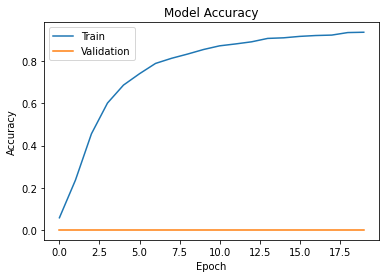

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

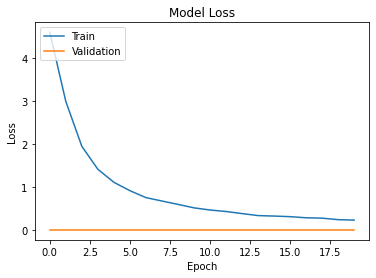

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import keras
import pickle
import json

from keras.models import save_model

model.save('models/my_model')

with open('utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

INFO:tensorflow:Assets written to: models/my_model\assets


INFO:tensorflow:Assets written to: models/my_model\assets
